**NOTE** Currently this notebook runs with MlpMixer on GPUs and TPUs, but Vision
Transformers only run on GPUs. This is due to a temporary regression in the TPU
Node setup that is used for Colab and will be fixed soon.

See code at https://github.com/google-research/vision_transformer/

See papers at

- Vision Transformer: https://arxiv.org/abs/2010.11929
- MLP-Mixer: https://arxiv.org/abs/2105.01601

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

##### Copyright 2021 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [2]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'no'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/vision_transformer_colab'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

In [3]:
# Clone repository and pull latest changes.
# ![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
# !cd vision_transformer && git pull

In [4]:
# !pip install -qr vision_transformer/vit_jax/requirements.txt

### Imports

In [5]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [6]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-L_16'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

In [7]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [8]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)]

In [9]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
# from google.colab import files
# files.view('vision_transformer/vit_jax/configs/common.py')
# files.view('vision_transformer/vit_jax/configs/models.py')
# files.view('vision_transformer/vit_jax/checkpoint.py')
# files.view('vision_transformer/vit_jax/input_pipeline.py')
# files.view('vision_transformer/vit_jax/momentum_clip.py')
# files.view('vision_transformer/vit_jax/train.py')

In [10]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

In [11]:
# Helper functions for images.

# labelnames = dict(
#   # https://www.cs.toronto.edu/~kriz/cifar.html
#   cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
#   # https://www.cs.toronto.edu/~kriz/cifar.html
#   cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
# )

labelnames = dict()
dataset_dir = '/mnt/homeGPU/aurrea_cpelaez/datasets/VMMRdb_splits/'
for split in ['brand', 'brand_model', 'brand_model_year']:
    classes_path = os.path.join(dataset_dir, split, 'classes.txt')
    with open(classes_path, 'r') as f:
        labelnames[f'vmmrdb_{split}'] =  tuple(map(lambda line: line.strip(), f.readlines()))

def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [12]:
dataset = 'vmmrdb_brand_model_year'
batch_size = 256

In [13]:
# Code to add custom dataset

import tensorflow_datasets as tfds
import ml_collections
import vmmrdb_brand.vmmrdb_brand_dataset_builder
import vmmrdb_brand_model.vmmrdb_brand_model_dataset_builder
import vmmrdb_brand_model_year.vmmrdb_brand_model_year_dataset_builder


for dataset_name in ['vmmrdb_brand', 'vmmrdb_brand_model', 'vmmrdb_brand_model_year']:
    common_config.DATASET_PRESETS[dataset_name] = ml_collections.config_dict.config_dict.ConfigDict({
      'pp': {
        'crop': 384,
        'resize': 448, 
        'test': 'test',
        'train': 'train'
      },
      'total_steps': 10000
    })


tfds.load(dataset, split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)
input_pipeline.get_dataset_info(dataset, 'train')

INFO:absl:Load dataset info from /home/cpelaez/tensorflow_datasets/vmmrdb_brand_model_year/1.0.0
INFO:absl:Reusing dataset vmmrdb_brand_model_year (/home/cpelaez/tensorflow_datasets/vmmrdb_brand_model_year/1.0.0)
2024-09-19 13:31:56.266965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/usr/local/cuda/lib
2024-09-19 13:31:56.267021: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
INFO:absl:Constructing tf.data.Dataset vmmrdb_brand_model_year for split ['train', 'test'], from /home/cpelaez/te

{'num_examples': 139075, 'num_classes': 2439}

In [14]:
pp_config = common_config.DATASET_PRESETS[dataset]['pp']
if model_name.startswith('Mixer'):
  # Mixer tokens are fixed.
  pp_config['crop'] = 224
  pp_config['resize'] = 256
else:
  pp_config['crop'] = 384
  pp_config['resize'] = 384
pp_config

crop: 384
resize: 384
test: test
train: train

In [15]:
# Note the datasets are configured in input_pipeline.DATASET_PRESETS
# Have a look in the editor at the right.
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
# tf.data.Datset for training, infinite repeats.
ds_train = input_pipeline.get_data(
    dataset=dataset, mode='train', repeats=None, batch_size=batch_size,
    pp_config=pp_config, inception_crop=False
)
# tf.data.Datset for evaluation, single repeat.
ds_test = input_pipeline.get_data(
    dataset=dataset, mode='test', repeats=1, batch_size=batch_size,
    pp_config=pp_config,
)

INFO:absl:Load dataset info from /home/cpelaez/tensorflow_datasets/vmmrdb_brand_model_year/1.0.0
INFO:absl:Load dataset info from /home/cpelaez/tensorflow_datasets/vmmrdb_brand_model_year/1.0.0
INFO:absl:Load dataset info from /home/cpelaez/tensorflow_datasets/vmmrdb_brand_model_year/1.0.0
INFO:absl:Reusing dataset vmmrdb_brand_model_year (/home/cpelaez/tensorflow_datasets/vmmrdb_brand_model_year/1.0.0)
INFO:absl:Constructing tf.data.Dataset vmmrdb_brand_model_year for split train, from /home/cpelaez/tensorflow_datasets/vmmrdb_brand_model_year/1.0.0
INFO:absl:Load dataset info from /home/cpelaez/tensorflow_datasets/vmmrdb_brand_model_year/1.0.0
INFO:absl:Load dataset info from /home/cpelaez/tensorflow_datasets/vmmrdb_brand_model_year/1.0.0
INFO:absl:Reusing dataset vmmrdb_brand_model_year (/home/cpelaez/tensorflow_datasets/vmmrdb_brand_model_year/1.0.0)
INFO:absl:Constructing tf.data.Dataset vmmrdb_brand_model_year for split test, from /home/cpelaez/tensorflow_datasets/vmmrdb_brand_mod

In [16]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(4, 64, 384, 384, 3)

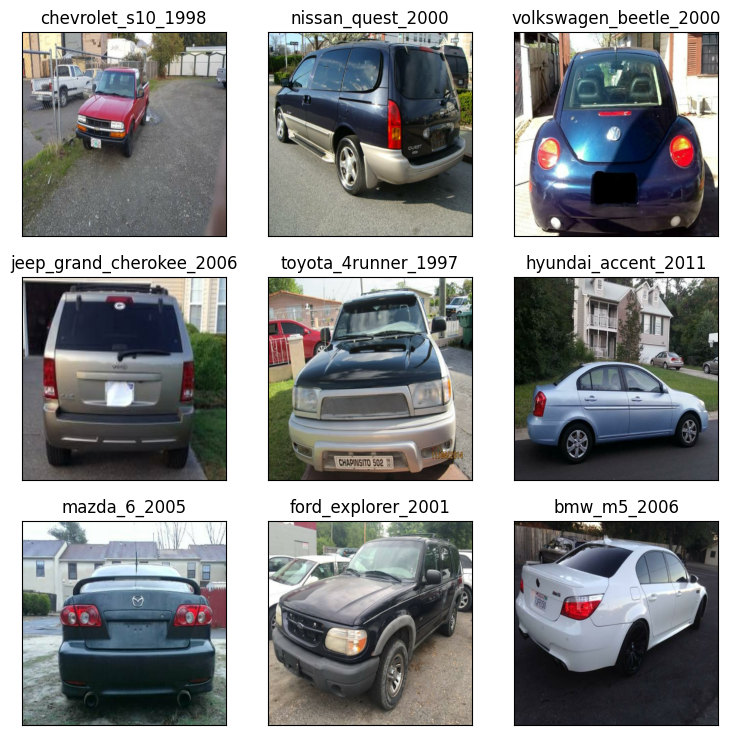

In [17]:
# Show some imags with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

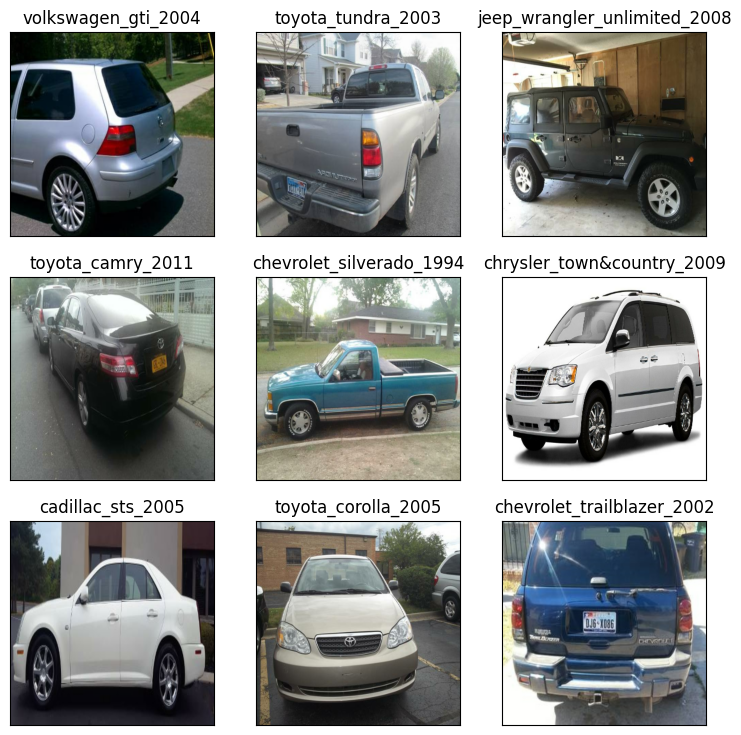

In [18]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [19]:
config = common_config.get_config()
config.model = models_config.MODEL_CONFIGS[model_name]
config

accum_steps: 8
base_lr: 0.03
batch: 512
batch_eval: 512
checkpoint_every: 1000
dataset: null
decay_type: cosine
eval_every: 100
grad_norm_clip: 1.0
mixup_alpha: 0.0
model:
  classifier: token
  hidden_size: 1024
  name: ViT-L_16
  patches:
    size: !!python/tuple
    - 16
    - 16
  representation_size: null
  transformer:
    attention_dropout_rate: 0.0
    dropout_rate: 0.1
    mlp_dim: 4096
    num_heads: 16
    num_layers: 24
model_or_filename: null
optim_dtype: bfloat16
pp: null
prefetch: 2
pretrained_dir: .
progress_every: 10
shuffle_buffer: 50000
tfds_data_dir: null
tfds_manual_dir: null
total_steps: null
trainer: train
warmup_steps: 500

In [20]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('ViT'):
  model = models.VisionTransformer(num_classes=num_classes, **config.model)
elif model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **config.model)
else:
  raise ValueError(f'Unknown model class: "{model_name}"')
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

2024-09-19 13:34:46.279097: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [21]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=config.model,
)

INFO:absl:Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
INFO:absl:load_pretrained: drop-head variant
INFO:absl:load_pretrained: resized variant: (1, 197, 1024) to (1, 577, 1024)
INFO:absl:load_pretrained: grid-size from 14 to 24


### Evaluate

In [22]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: DeviceArray (2439,)
params_repl.cls: ShardedDeviceArray (4, 2439)


In [23]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [24]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [25]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

INFO:absl:Load dataset info from /home/cpelaez/tensorflow_datasets/vmmrdb_brand_model_year/1.0.0
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 316/316 [13:33<00:00,  2.57s/it]


DeviceArray(0.00017306, dtype=float32)

### Fine-tune

In [26]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
# total_steps = 665 # ~ one epoch for vmmrdb_brand
# total_steps = 656 # ~ one epoch for vmmrdb_brand_model
# total_steps = 544 # ~ one epoch for vmmrdb_brand_model_year
total_steps = 656 * 16
warmup_steps = 30 # 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 16 # We are training on 4 GPUs (64/4) # 8
base_lr = 0.03

In [27]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

In [28]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10496/10496 [23:51:33<00:00,  8.18s/it]


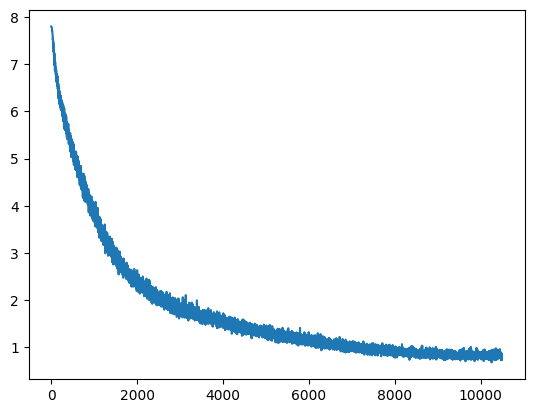

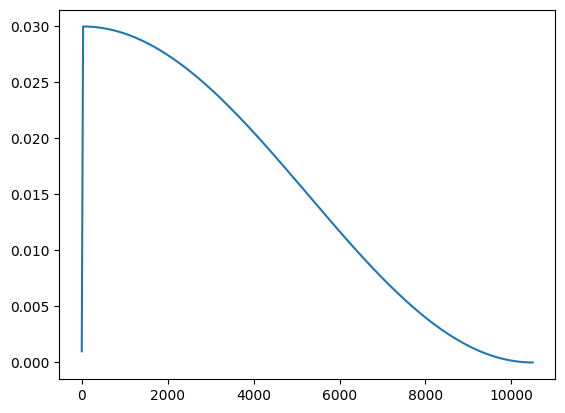

In [29]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [30]:
# Should be ~96.7% for Mixer-B/16 on CIFAR10
get_accuracy(opt_repl.target)

INFO:absl:Load dataset info from /home/cpelaez/tensorflow_datasets/vmmrdb_brand_model_year/1.0.0
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 316/316 [13:14<00:00,  2.51s/it]


DeviceArray(0.4109845, dtype=float32)

In [31]:
from vit_jax.test_utils import _save

def save(params, path):
    _save(params, path)

save(flax.jax_utils.unreplicate(opt_repl.target), f'./{model_name}_{dataset}_{step}.npz')